In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import randint, uniform

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier
from catboost import Pool
import catboost as cb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from itertools import product,chain

import plotly.express as px


# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add project root to sys.path
sys.path.append(project_root)
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Import and reload my custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import feature_selection as fs
from scripts import clustering as cl
from scripts import variables as var
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(fs)
importlib.reload(cl)
importlib.reload(var)


# Import from cloned github repos
import hyperopt
print(hyperopt.__file__)
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
import hyperopt.pyll.stochastic
################ DEFINE column variables from data ###################
from scripts.variables import id_columns, daily_cols_v1, daily_v2_common 
from scripts.variables import phq2_cols, phq9_cols, weekly_cols, passive_cols, survey_cols

## Load in dfs scaled
df_names = ['v1_day', 'v2_day', 'v1_week']
df_pca = ['v1_day_pca', 'v1_week_pca']
df_all = df_names + df_pca

<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
/opt/anaconda3/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
Failed to load cloudpickle, try installing cloudpickle via "pip install cloudpickle" for enhanced pickling support.


/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/git_repos/hyperopt_repo/hyperopt/__init__.py


In [ ]:
#### Simple linear regression
from sklearn.linear_model import LinearRegression
# Step 1: Set x_cols to the various V1 PCs
y_var = 'pc_depression_phq2'
data = pd.read_csv(os.path.join(brighten_dir, 'v1_day_pca.csv'))
#print(data.columns.to_list())
results = pd.DataFrame()
count=0
x_cols = [col for col in data.columns.to_list() if 'pc_' in col and col!=y_var]
y_col = [y_var]

reg = LinearRegression().fit(data[x_cols], data[y_col])
print(reg.score(data[x_cols], data[y_col]))
print(reg.coef_)
print(reg.intercept_)

0.0032143094652498094
[[0.00429332 0.00113432 0.09436832]]
[0.0440816]


In [ ]:
######### Mixed LM Model V1 vs phq2_sum #########
###### V1 PCs vs phq2_sum #########
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.api as sm
import statsmodels.formula.api as smf

ignore_cols = ['num_id', 'dt', 'week', 'day']
y_var = 'phq9_sum_cat'
data = pd.read_csv(os.path.join(brighten_dir, 'v1_week_res.csv'))
results = pd.DataFrame()
count = 0
x_cols = [col for col in data.columns.to_list() if 'phq9' not in col and col not in ignore_cols]
data_full = data[x_cols + [y_var, 'num_id']].copy().dropna()
data_full["num_id"] = data_full["num_id"].astype("category")
display(data_full)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

model = smf.mixedlm(f"{y_var} ~ mobility  + sms_count + unreturned_calls + phq2_sum", 
                    data=data_full, 
                    groups=data_full["num_id"])
result = model.fit()
print(f'Relationship to y_col {y_var}, Nested Linear Regression on "num_id"')
print(result.summary())



### Model Selection - Classfication

We'll start by using several of the most popular classifiers with default parameters and compare how well they perform to indentify which might be best to proceed with.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import LinearSVC, LinearSVR
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
import xgboost as xgb

regs = [
    ('Linear SVM', LinearSVR(random_state=42, max_iter=1000, dual='auto')),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(objective='reg:squarederror', random_state=42)),
    ('AdaBoost', AdaBoostRegressor(random_state=42)),
    ('Gradient Boost', GradientBoostingRegressor(random_state=42)),
    ('Bagging', BaggingRegressor(random_state=42)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=0))
]

regs_full = [
    ('Decision Tree', DecisionTreeRegressor()),
    ('Linear SVM', LinearSVR(random_state=42, max_iter=1000, dual='auto')),
]
regs_someNA = [
    ('Hist Gradient Tree', HistGradientBoostingRegressor()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(objective='reg:squarederror', random_state=42)),
    ('AdaBoost', AdaBoostRegressor(random_state=42)),
    ('Gradient Boost', GradientBoostingRegressor(random_state=42)),
    ('Bagging', BaggingRegressor(random_state=42)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=0))
]


scikit-learn: 1.6.1
xgboost: 2.1.1


We'll use cross-validation to get a better understanding of each models performance, rather than just a single test. Let's create a KFold object so we can use the same folds for each classifier.


In [ ]:
print('id columns ignoring:',id_columns)
for name in df_names:
    results[name] = {}
    X_train = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_train.csv'))
    y_train= pd.read_csv(os.path.join(brighten_dir, f'{name}_y_train.csv'))
    
    X_train_cleaned = X_train.drop(columns=[col for col in X_train.columns if col in id_columns or 'Unnamed' in col])
    y_train_cleaned = y_train.drop(columns=[col for col in y_train.columns if 'Unnamed' in col]).squeeze()
    print(f'X columns {X_train_cleaned.columns}')


id columns ignoring: ['num_id', 'dt', 'week', 'day']
X columns Index(['idx', 'sms_count', 'call_count', 'unreturned_calls',
       'aggregate_communication', 'interaction_diversity', 'call_duration',
       'sms_length', 'mobility_radius', 'mobility', 'gender', 'age', 'race'],
      dtype='object')
X columns Index(['idx', 'humidity_std', 'dew_point_std', 'humidity_IQR',
       'cloud_cover_IQR', 'cloud_cover_mean', 'humidity_mean', 'dew_point_IQR',
       'humidity_median', 'precip_sum', 'cloud_cover_median', 'temp_mean',
       'dew_point_median', 'dew_point_mean', 'temp_std', 'temp_median',
       'temp_IQR', 'cloud_cover_std', 'location_variance_hr',
       'hours_high_speed_transportation_hr', 'hours_walking_hr',
       'distance_walking_hr', 'distance_active_hr',
       'distance_powered_vehicle_hr', 'distance_high_speed_transportation_hr',
       'hours_powered_vehicle_hr', 'hours_stationary_nhw_hr',
       'hours_stationary_hr', 'hours_active_hr', 'hours_of_sleep_hr', 'gender',


## Run the classifiers (binary variable targets-- V1 Day and V2 Day)

In [ ]:
# results = {}
# for name in df_names:
#     if 'day' in name:
#         results[name] = {}
#         X_train = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_train.csv'))
#         y_train= pd.read_csv(os.path.join(brighten_dir, f'{name}_y_train.csv'))

#         X_train_cleaned = X_train.drop(columns=[col for col in X_train.columns if col in id_columns or 'Unnamed' in col])
#         y_train_cleaned = y_train.drop(columns=[col for col in y_train.columns if 'Unnamed' in col]).squeeze()
#         # Create KFold object with 10 folds
#         kf = KFold(n_splits=10, shuffle=True, random_state=42)

#         # Evaluate each classifier using cross-validation
#         for clf_name, clf in clfs:
#             cv_scores = cross_val_score(clf, X_train_cleaned, y_train_cleaned, cv=kf)
#             results[name][clf_name] = cv_scores


In [5]:
# # Extract data to flattened df for plotting
# flat_results = []

# for dataset_name, clf_results in results.items():
#     for clf_name, scores in clf_results.items():
#         for score in scores:
#             flat_results.append({
#                 'Dataset': dataset_name,
#                 'Classifier': clf_name,
#                 'Score': score
#             })

# results_df = pd.DataFrame(flat_results)

# plt.figure(figsize=(14, 8))
# sns.boxplot(x='Classifier', y='Score', hue='Dataset', data=results_df)
# plt.xticks(rotation=45)
# plt.title('Cross-Validation Scores by Classifier and Dataset')
# plt.show()


Using group K fold because we have subject data

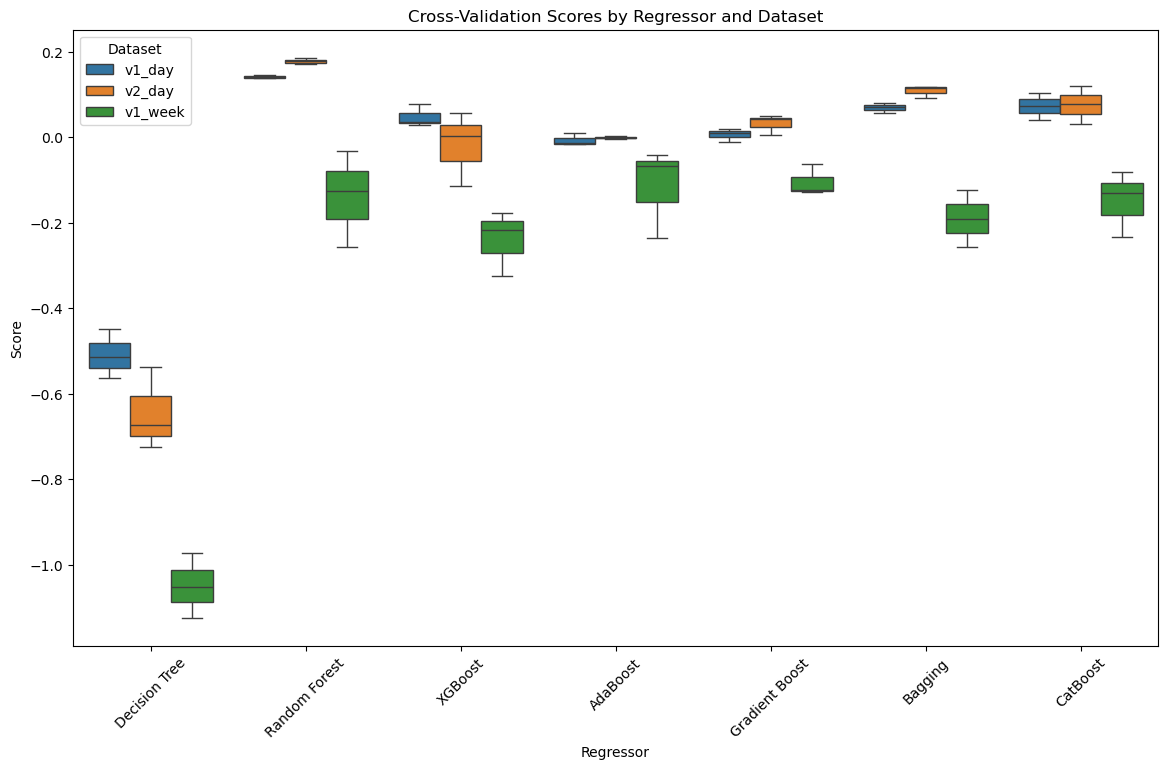

In [ ]:
from sklearn.model_selection import GroupKFold, cross_val_score
id_columns.append('idx')
results = {}
for name in df_names:
    results[name] = {}
    X_train = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_train.csv'))
    X_test = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_test.csv'))
    y_train= pd.read_csv(os.path.join(brighten_dir, f'{name}_y_train.csv'))
    y_test= pd.read_csv(os.path.join(brighten_dir, f'{name}_y_test.csv'))

    # Create KFold object which groups based on num ID
    gkf = GroupKFold(n_splits=3)
    groups = X_train['num_id']    # Set num_id for the groups
    # Now drop all other id columns 
    X_train_cleaned = X_train.drop(columns=[col for col in X_train.columns if col in id_columns or 'Unnamed' in col])
    y_train_cleaned = y_train.drop(columns=[col for col in y_train.columns if 'Unnamed' in col]).squeeze() #squeeze into a list from a series
    # Evaluate each classifier using cross-validation
    for reg_name, reg in regs_full:
        cv_scores = cross_val_score(reg, X_train_cleaned, y_train_cleaned, groups=groups, cv=gkf, scoring='r2')
        results[name][reg_name] = cv_scores


# Extract data to flattened df for plotting
flat_results = []

for dataset_name, reg_results in results.items():
    for reg_name, scores in reg_results.items():
        for score in scores:
            flat_results.append({
                'Dataset': dataset_name,
                'Regressor': reg_name,
                'Score': score
            })


results_df = pd.DataFrame(flat_results)

plt.figure(figsize=(14, 8))
sns.boxplot(x='Regressor', y='Score', hue='Dataset', data=results_df)
plt.xticks(rotation=45)
plt.title('Cross-Validation Scores by Regressor and Dataset')
plt.show()


stopped 0429 3:25 pm 

## From this we can see Random Forest is the best performing algorithm.

Since we have much more data for V1 day than V2 day, and also have communication features in V1 day, it makes sense that it has a higher accuracy.

We'll focus on the day regressors, and on randomforest, as it does well for both V1 day and V2 day.

In [14]:
## Random Forest Random Search
results = {}
for name in df_names:
    print(f"--- Dataset: {name} ---")
    X_train_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_train.csv'))
    y_train_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_train.csv'))
    # test
    X_test_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_test.csv'))
    y_test_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_test.csv'))

    X_train = X_train_unclean.drop(columns=[col for col in X_train_unclean.columns if col in id_columns or 'Unnamed' in col])
    y_train = y_train_unclean.drop(columns=[col for col in y_train_unclean.columns if 'Unnamed' in col]).squeeze()
    X_test = X_test_unclean.drop(columns=[col for col in X_test_unclean.columns if col in id_columns or 'Unnamed' in col])
    y_test = y_test_unclean.drop(columns=[col for col in y_test_unclean.columns if 'Unnamed' in col]).squeeze()

    # Define parameter grid based on dataset
    param_grid = {
            'n_estimators': [100, 200, 500, 1000],
            'max_depth': [None, 5, 10, 20, 30, 50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4, 10],
            'max_features': [None, "sqrt", "log2", 0.5, 0.75],
        }

    # Initialize the CatBoostClassifier
    model = RandomForestRegressor(random_state=42)

    # Perform grid search
    grid = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=100,
        scoring='r2',
        n_jobs=-1,
        random_state=42,
        error_score='raise'
    )

    # Log best results
    grid.fit(X_train, y_train)

    best_params = grid.best_params_

    final_model = RandomForestRegressor(**best_params, random_state=42)

    final_model.fit(X_train, y_train)
    score = final_model.score(X_test, y_test)

    results[name] = {
        "best_params": best_params,
        "best_score": score
        }
 
    print(results[name])

--- Dataset: v1_day ---


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'best_params': {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.75, 'max_depth': 20}, 'best_score': 0.056387154383319205}
--- Dataset: v2_day ---


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'best_params': {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}, 'best_score': 0.14606447330732053}
--- Dataset: v1_week ---
{'best_params': {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 5}, 'best_score': -0.19867174660385056}


In [15]:
results

{'v1_day': {'best_params': {'n_estimators': 500,
   'min_samples_split': 10,
   'min_samples_leaf': 4,
   'max_features': 0.75,
   'max_depth': 20},
  'best_score': 0.056387154383319205},
 'v2_day': {'best_params': {'n_estimators': 1000,
   'min_samples_split': 2,
   'min_samples_leaf': 2,
   'max_features': None,
   'max_depth': None},
  'best_score': 0.14606447330732053},
 'v1_week': {'best_params': {'n_estimators': 500,
   'min_samples_split': 2,
   'min_samples_leaf': 10,
   'max_features': 'log2',
   'max_depth': 5},
  'best_score': -0.19867174660385056}}

### Some NaN values
Not imputed

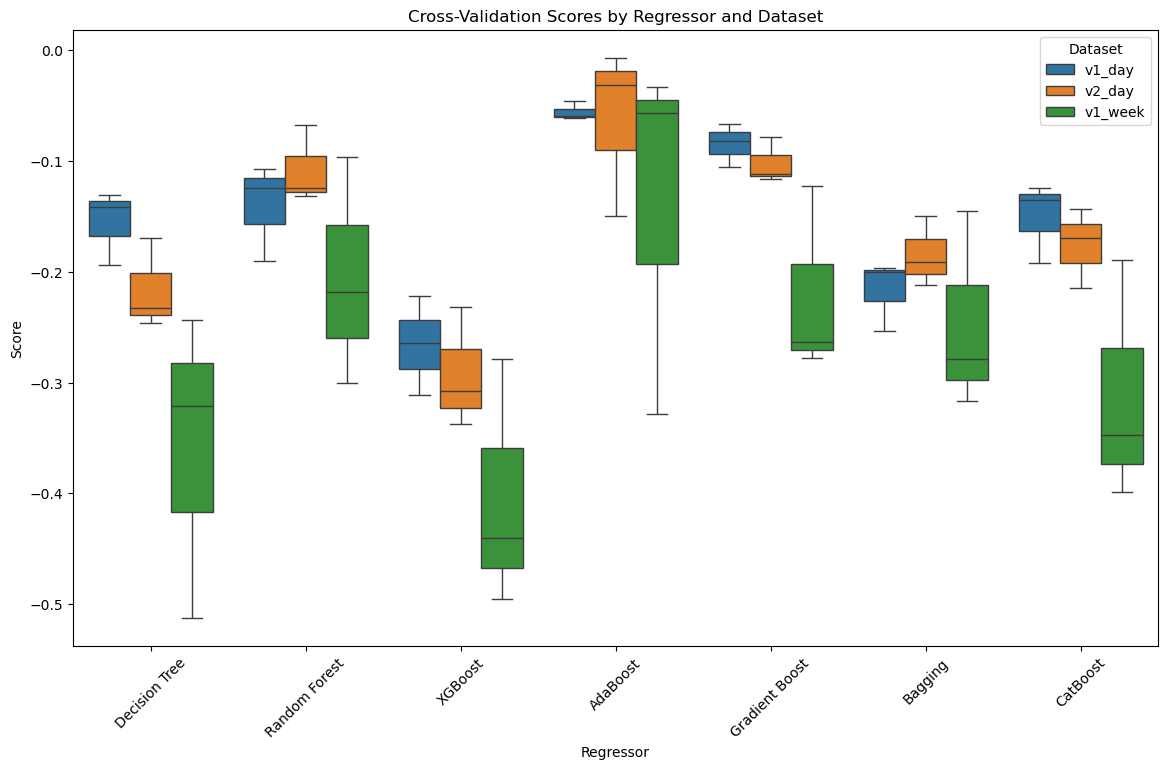

In [4]:
from sklearn.model_selection import GroupKFold, cross_val_score
id_columns.append('idx')
results = {}
for name in df_names:
    results[name] = {}
    X_train = pd.read_csv(os.path.join(brighten_dir, f'{name}_wNA_X_train.csv'))
    X_test = pd.read_csv(os.path.join(brighten_dir, f'{name}_wNA_X_test.csv'))
    y_train= pd.read_csv(os.path.join(brighten_dir, f'{name}_wNA_y_train.csv'))
    y_test= pd.read_csv(os.path.join(brighten_dir, f'{name}_wNA_y_test.csv'))

    # Create KFold object which groups based on num ID
    gkf = GroupKFold(n_splits=3)
    groups = X_train['num_id']    # Set num_id for the groups
    # Now drop all other id columns 
    X_train_cleaned = X_train.drop(columns=[col for col in X_train.columns if col in id_columns or 'Unnamed' in col])
    y_train_cleaned = y_train.drop(columns=[col for col in y_train.columns if 'Unnamed' in col]).squeeze() #squeeze into a list from a series
    # Evaluate each classifier using cross-validation
    for reg_name, reg in regs_someNA:
        cv_scores = cross_val_score(reg, X_train_cleaned, y_train_cleaned, groups=groups, cv=gkf, scoring='r2')
        results[name][reg_name] = cv_scores


# Extract data to flattened df for plotting
flat_results = []

for dataset_name, reg_results in results.items():
    for reg_name, scores in reg_results.items():
        for score in scores:
            flat_results.append({
                'Dataset': dataset_name,
                'Regressor': reg_name,
                'Score': score
            })


results_df = pd.DataFrame(flat_results)

plt.figure(figsize=(14, 8))
sns.boxplot(x='Regressor', y='Score', hue='Dataset', data=results_df)
plt.xticks(rotation=45)
plt.title('Cross-Validation Scores by Regressor and Dataset')
plt.show()


In [ ]:
## Catboost RandomSearch
#results = {}
#for name in df_names:
print(f"--- Dataset: {name} ---")
X_train_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_train.csv'))
y_train_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_train.csv'))
# test
X_test_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_test.csv'))
y_test_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_test.csv'))

X_train = X_train_unclean.drop(columns=[col for col in X_train_unclean.columns if col in id_columns or 'Unnamed' in col])
y_train = y_train_unclean.drop(columns=[col for col in y_train_unclean.columns if 'Unnamed' in col]).squeeze()
X_test = X_test_unclean.drop(columns=[col for col in X_test_unclean.columns if col in id_columns or 'Unnamed' in col])
y_test = y_test_unclean.drop(columns=[col for col in y_test_unclean.columns if 'Unnamed' in col]).squeeze()

# Define parameter grid based on dataset
if name == "v1_day":
    param_grid = {
            'n_estimators': [i for i in range(50, 200)],
            'learning_rate': [round(x, 2) for x in np.arange(0.05, 1.05, 100)],
            'subsample': [i for i in np.linspace(0.01, 0.99, 100)],
        }
elif name == "v2_day":
    param_grid = {
            'n_estimators': [i for i in range(50, 200)],
            'learning_rate': [round(x, 2) for x in np.arange(0.05, 1.05, 100)],
            'subsample': [i for i in np.linspace(0.01, 0.99, 100)],
        }

# Initialize the CatBoostClassifier
model = GradientBoostingClassifier(random_state=42, verbose=0)

# Perform grid search
grid = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=100,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    error_score='raise'
)

# Log best results
grid.fit(X_train, y_train)

best_params = grid.best_params_

final_model = GradientBoostingClassifier(**best_params, random_state=42)

final_model.fit(X_train, y_train)
score = final_model.score(X_test, y_test)

results[name] = {
    "best_params": best_params,
    "best_score": score
    }

print(results[name])

The best parameters for each model are saved into {name}_catboost_gridsearch_results.json. From this we've gotten the 'best parameters' found, as well as an accuracy score. We can use these accuracy scores to compare to the increases in accuracy from optimizing hyperparameters.

## more specified hyperparameter optimization
From those parameter dicts we can make the parameter space smaller and more specifically find the optimal parameters for each aspect of the model. We'll use a random search still to decrease the compute time, but increase the iterations and decrease the ranges for each parameter.

We can then use the optimized hyperparameters and evaluate the accuracy score of the final model.

We'll use RMSE because we're interested in generally predicting the area of the depression score each subject is in.

In [ ]:
optimized_results = {}
for name in df_names:
    print(f"--- Dataset: {name} ---")
    X_train_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_train.csv'))
    y_train_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_train.csv'))
    # test
    X_test_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_test.csv'))
    y_test_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_test.csv'))

    X_train = X_train_unclean.drop(columns=[col for col in X_train_unclean.columns if col in id_columns or 'Unnamed' in col])
    y_train = y_train_unclean.drop(columns=[col for col in y_train_unclean.columns if 'Unnamed' in col]).squeeze()
    X_test = X_test_unclean.drop(columns=[col for col in X_test_unclean.columns if col in id_columns or 'Unnamed' in col])
    y_test = y_test_unclean.drop(columns=[col for col in y_test_unclean.columns if 'Unnamed' in col]).squeeze()

    # Define parameter grid based on dataset
    if name == "v1_day":
        param_grid = {
            'n_estimators': [i for i in range(120, 150)],
            'max_depth': [i for i in range(8, 20)],
            'min_samples_split': [i for i in range(50, 100)],
            'min_samples_leaf': [i for i in range(xx)],
            'max_features': [i for i in range(4, 12)],
            }
    elif name == "v2_day":
        param_grid = {
            'n_estimators': [i for i in range(50, 200)],
            'max_depth': [i for i in range(2, 15)],
            'min_samples_split': [i for i in range(50, 500)],
            'min_samples_leaf': [i for i in range(50, 500)],
            'max_features': [i for i in range(4, 12)],
        }
    elif name == "v1_week":
        param_grid = {
            'n_estimators': [i for i in range(120, 150)],
            'max_depth': [i for i in range(8, 20)],
            'min_samples_split': [i for i in range(50, 100)],
            'min_samples_leaf': [i for i in range(xx)],
            'max_features': [i for i in range(4, 12)],
        }
    
    # Initialize the CatBoostClassifier
    model = GradientBoostingClassifier(random_state=42, verbose=0)

    # Perform grid search
    grid = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=500,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )

    # Log best results
    grid.fit(X_train, y_train)

    best_params = grid.best_params_
    optimized_results[name] = {"best_params": best_params}

    final_model = GradientBoostingClassifier(**best_params, random_state=42)

    final_model.fit(X_train, y_train)
    score = final_model.score(X_test, y_test)

    optimized_results[name] = {
        "best_params": best_params,
        "best_score": score
        }

    print(optimized_results[name])



--- Dataset: v1_day ---
{'best_params': {'subsample': 0.651503006012024, 'n_estimators': 52, 'learning_rate': 0.0001}, 'best_score': 0.673939393939394}
--- Dataset: v2_day ---
{'best_params': {'subsample': 0.999, 'n_estimators': 152, 'learning_rate': 0.0001}, 'best_score': 0.522673031026253}
--- Dataset: v1_week ---
{'best_params': {'subsample': 0.676753507014028, 'n_estimators': 52, 'learning_rate': 0.0001}, 'best_score': 0.24285714285714285}


#### Increased random search results
Now we can see the best parameters for each dataset, as well as the accuracy over all crossfolds. 

v1_day_predictions.json:
{
    "accuracy": 0.674
}  

v2_day_predictions.json:
{
    "accuracy": 0.523
}  

v1_week_predictions.json:
{
    "accuracy": 0.243
}


### Evaluating results
We can now see the accuracy of each loosely-optimized hyperparameter model and increased-optimized hyperparameter model. We compare the accuracies in this below chart: 

In [106]:
results_df = pd.DataFrame(results).reset_index()
results_df['loose_model'] = 'loose_model'
opt_results_df = pd.DataFrame(optimized_results).reset_index()
opt_results_df['optimized_model'] = 'optimized_model'
total = pd.concat([results_df, opt_results_df], axis=0)
total = total[total['index']=='best_score']
total['model'] = total['loose_model'].astype(str).replace('nan','') + total['optimized_model'].astype(str).replace('nan','')
total = total.drop(columns=['optimized_model','loose_model'])
df_melted = total.melt( # Melt the DataFrame
    id_vars=['model'],
    value_vars=['v1_day', 'v2_day', 'v1_week'],
    var_name='variable',
    value_name='score'
)
fig = px.bar(
    df_melted,
    x='variable',    # x-axis: v1_day, v2_day, v1_week
    y='score',       # y-axis: score value
    color='model',   # bar color: loose_model vs optimized_model
    barmode='group', # grouped bars next to each other
    text='score',    # show value labels
    title='Model Comparison Across v1_day, v2_day, and v1_week',
    labels={'variable': 'Dataset', 'score': 'Accuracy Score'}
)

fig.show()


Tuning the hyperparameters further gave us an increase in accuracy for v1_week by about 5%. For v1_day it didn't change and for v1_week it deceased around 3%.

### Bayesian Hyperparameter Optimization
This took over 9 hours and still didn't converge, so let's try another method. 

First we'll try to optimize hyperparameters for KNN.

In [30]:
from sklearn.metrics import accuracy_score
name = 'v1_day'
X_train_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_train.csv'))
X_train_cleaned = X_train_df.drop(columns=[col for col in X_train_df.columns if col in id_columns or 'Unnamed' in col])
y_train_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_train.csv'))
y_train_cleaned = y_train_df.drop(columns=[col for col in y_train_df.columns if 'Unnamed' in col]).squeeze()

X_test_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_test.csv'))
X_test_cleaned = X_test_df.drop(columns=[col for col in X_test_df.columns if col in id_columns or 'Unnamed' in col])
y_test_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_test.csv'))
y_test_cleaned = y_test_df.drop(columns=[col for col in y_test_df.columns if 'Unnamed' in col]).squeeze()

X_df = pd.concat([X_train_cleaned, X_test_cleaned], axis=0)
y_df = pd.concat([y_train_cleaned, y_test_cleaned], axis=0)

X = X_df.to_numpy()
y = y_df.to_numpy()
X_train = X_train_cleaned.to_numpy()
y_train = y_train_cleaned.to_numpy()
X_test = X_test_cleaned.to_numpy()
y_test = y_test_cleaned.to_numpy()


def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1, 31)),  # 30 values
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
    'leaf_size': hp.quniform('leaf_size', 10, 50, 1)
}

def f(params):
    clf = KNeighborsClassifier(
        n_neighbors=params['n_neighbors'],
        weights=params['weights'],
        algorithm=params['algorithm'],
        leaf_size=int(params['leaf_size'])
    )
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    return {'loss': -acc, 'status': STATUS_OK}
    # acc = cross_val_score(clf, X_train, y_train, cv=5).mean()  # Use cross-validation    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print(f'best: {best}')


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

job exception: ('switch argument was', 1)



  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


TypeError: ('switch argument was', 1)

In [ ]:
f, ax = plt.subplots(1)#, figsize=(10,10))
xs = [t['misc']['vals']['n'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_title('Iris Dataset - KNN', fontsize=18)
ax.set_xlabel('n_neighbors', fontsize=12)
ax.set_ylabel('cross validation accuracy', fontsize=12)

In [27]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
print(type(X))
y = iris.target
print(type(y))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
